In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from Config import plot_config
plot_config()

In [2]:
from pybendt.pseudorandom import Pseudorandom
from pybendt.atom import Atom, friction_from_hydrodynamic_radius_and_viscosity
from pybendt.interaction import *
from pybendt.reaction import *

In [3]:
friction = friction_from_hydrodynamic_radius_and_viscosity(hydradius = 10.0, viscosity = 1.0)

In [4]:
pseudorandom = Pseudorandom(dimensions = 2, seed = 14)

In [5]:
a1 = Atom([-20.0, -10.0], friction, dimensions = 2, color = 'red')
a2 = Atom([-20.0, 10.0], friction, dimensions = 2, color = 'blue')
a3 = Atom([0.0, 0.0], friction, dimensions = 2, color = 'black')
a4 = Atom([20.0, 10.0], friction, dimensions = 2, color = 'blue')
a5 = Atom([20.0, -10.0], friction, dimensions = 2, color = 'red')
atoms = [a1, a2, a3, a4, a5]

In [6]:
i1 = a1.add_interaction(a2, harmonic_force, harmonic_energy, {"force_constant": 1.0, "equilibrium_distance": 20.0})
i2 = a1.add_interaction(a3, harmonic_force, harmonic_energy, {"force_constant": 0.08, "equilibrium_distance": np.sqrt(500.0)})
i3 = a2.add_interaction(a3, harmonic_force, harmonic_energy, {"force_constant": 0.08, "equilibrium_distance": np.sqrt(500.0)})
i4 = a3.add_interaction(a4, harmonic_force, harmonic_energy, {"force_constant": 0.08, "equilibrium_distance": np.sqrt(500.0)})
i5 = a3.add_interaction(a5, harmonic_force, harmonic_energy, {"force_constant": 0.08, "equilibrium_distance": np.sqrt(500.0)})
i6 = a4.add_interaction(a5, harmonic_force, harmonic_energy, {"force_constant": 1.0, "equilibrium_distance": 20.0})
interactions = []
for a in atoms:
    for i in a.interactions:
        if i not in interactions: interactions.append(i)

Initial structure

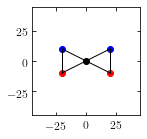

In [7]:
fig, ax = plt.subplots()
DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0]/2, DefaultSize[1]/2) )
nx=1
ny=1
grid = plt.GridSpec(nrows=ny, ncols=nx, wspace=0.2, hspace=0.8)
axa = plt.subplot(grid[0, 0])
_ = axa.set_aspect('equal')
_ = axa.set_xlim((-45,45))
_ = axa.set_ylim((-45,45))
for a in atoms:
    _ = axa.plot([a.position[0]], [a.position[1]], 'o', ms = 6, color = a.color)
for interaction in interactions:
    _ = axa.plot([interaction.atom1.position[0], interaction.atom2.position[0]], [interaction.atom1.position[1], interaction.atom2.position[1]], '-', color = 'black')

In [8]:
i7 = Interaction(None, None, harmonic_force, harmonic_energy, {"force_constant": 10.0, "equilibrium_distance": 35.0})
i8 = Interaction(None, None, harmonic_force, harmonic_energy, {"force_constant": 10.0, "equilibrium_distance": 35.0})

r1_rc1 = ReactionCondition([a1, a5], distance_condition, {"sign": "<", "reaction_distance": 35.0})
r1_rc2 = ReactionCondition([a2, a4], distance_condition, {"sign": "<", "reaction_distance": 35.0})

r1 = a1.add_reaction([r1_rc1, r1_rc2], [remove_interaction_effect]*2+[add_interaction_effect]*2, [{"interaction": i2}, {"interaction": i3}, {"interaction": i7, "atom1": a1, "atom2": a5}, {"interaction": i8, "atom1": a2, "atom2": a4}])

reactions = []
for a in atoms:
    for r in a.reactions:
        if r not in reactions: reactions.append(r)

In [9]:
timestep = 1.0
temperature = 310.0
N_steps = 10000

In [10]:
for index in range(N_steps):
    pointers = np.zeros((len(atoms), len(atoms), 2))
    distances = np.zeros((len(atoms), len(atoms)))
    id_to_index = {}
    for i in range(len(atoms)):
        id_to_index[atoms[i].id]=i
        for j in range(i):
            pointers[i][j] = atoms[j].position - atoms[i].position
            pointers[j][i] = -pointers[i][j]
            distances[i][j] = distances[j][i] = np.sqrt(np.sum(pointers[i][j]**2))

    reaction_happened = False
    for reaction in reactions:
        for reaction_condition in reaction.reaction_conditions:
            if reaction_condition.condition_function.__name__ == "distance_condition":
                reaction_condition.evaluate_condition(distances[id_to_index[reaction_condition.atoms[0].id]][id_to_index[reaction_condition.atoms[1].id]])
            if reaction.conditions_fulfilled():
                reaction.effect()
                reaction_happened = True

    # restart after reactions if needed
    if reaction_happened:
        interactions = []
        for a in atoms:
            for i in a.interactions:
                if i not in interactions: interactions.append(i)
        reactions = []
        for a in atoms:
            for r in a.reactions:
                if r not in reactions: reactions.append(r)

    E = 0
    for interaction in interactions:
        interaction.compute_force(distances[id_to_index[interaction.atom1.id]][id_to_index[interaction.atom2.id]],\
                                  pointers[id_to_index[interaction.atom1.id]][id_to_index[interaction.atom2.id]])
        interaction.compute_energy(distances[id_to_index[interaction.atom1.id]][id_to_index[interaction.atom2.id]])
        E += interaction.energy/kB_in_kcal_per_mole_per_kelvin/temperature

    for a in atoms:
        a.deterministic_move(timestep)
        a.brownian_move(timestep, temperature, pseudorandom.draw())
        a.reset_force()

interaction removed
interaction removed
interaction added
interaction added
reaction removed


Final structure

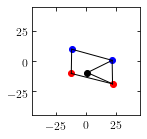

In [11]:
fig, ax = plt.subplots()
DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0]/2, DefaultSize[1]/2) )
nx=1
ny=1
grid = plt.GridSpec(nrows=ny, ncols=nx, wspace=0.2, hspace=0.8)
axa = plt.subplot(grid[0, 0])
_ = axa.set_aspect('equal')
_ = axa.set_xlim((-45,45))
_ = axa.set_ylim((-45,45))
for a in atoms:
    _ = axa.plot([a.position[0]], [a.position[1]], 'o', ms = 6, color = a.color)
for interaction in interactions:
    _ = axa.plot([interaction.atom1.position[0], interaction.atom2.position[0]], [interaction.atom1.position[1], interaction.atom2.position[1]], '-', color = 'black')